## IBM Data Science Coursera Capstone Project Jupyter Notebook

Author: Mark Hanson

#### Background
This Jupyter notebook will be used for the final capstone project in the Coursera IBM Data Science Professional class.  In brief the requirements are to leverage Foursquare location data to explore or compare any choosen neighborhoods or cities or to come up with a problem that can be soloved with data obtained with the Foursquare API. Upon investigation it was determined that Foursquare timeseries data is only available to verified managers of Foursquare venues which makes answering some more interesting questions more difficult.

Some suggested projects were:
1. Comparing previously analyzed neighborhoods of Toronto and New York to see how similar or dissimilar they are.
2. Finding out if New York is more Toronto or Paris or some other city
3. Finding a good location for a restaraunt or contractor.

#### Description of my capstone project
For my capstone project I have choosen to cluster the cities in the Minneapolis / Saint Paul metropolitan area similar to what was done in the labs.  However, in addition to using Foursquare data, I downloaded real estate value data from Zillow and plan to use this to add more detail for the clustering algorithm.  As I get into the analysis I may change or expand the scope or objective of the project by identifying a specific question to answer or adding some more analysis.

Changes / additions under consideration:
  Plot a choropleth style map of clusters to better visualize how the entire zipcode vs just the bubble marker
  Create a choropleth style heat map of median home prices by zipcode
  Calculate year over year percent change in median home value by zipcode to show which are increasing vs decreasing in value
  
  Zip code GeoJSON attributions - https://www.census.gov/cgi-bin/geo/shapefiles2010/layers.cgi
  https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md
  
1. Add income by zipcode information - difficult to process from available data
2. Analysis, regression, prediction of median home price change -  Modify df to add year over year % change in median home value
2. Crime rates - not interested in this data
3. Academic achievement - not interested in this data

### MP 1. Install and import packages

In [1]:
# Install geocoder package with conda
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#print('geopy installed!')

In [4]:
# install folium
#!conda install -c conda-forge folium=0.5.0 --yes
#print('folium installed!')

In [4]:
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [2]:
# import other modules
import pandas as pd
from pandas.io.json import json_normalize

import numpy as np
import requests
import json
import bs4
from bs4 import BeautifulSoup as bs

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
import folium

**Week 1 assignment**

In [3]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## MP 2. Import Zillow data

Data attribution: “Data acquired from Zillow.com/data on April 10, 2019. Aggregated data on this page is made freely available by Zillow for non-commercial use.”

**NOTE: While working on project, skip down to section MP 2 and import zill_MSP_data.csv or zill_MSP_data_test.csv instead of recreating entire df.**

In [5]:
zill_MNWI_df = pd.read_csv('Zillow_Home_Value_Index_MN_WI.csv')

In [6]:
zill_MNWI_df.shape

(826, 282)

Create a new dataframe with just Minneapolis-St. Paul-Bloomington Metro area, drop unused columns, rename ZipCode, and reset index

In [7]:
zill_MSP_df = zill_MNWI_df[zill_MNWI_df.Metro == 'Minneapolis-St. Paul-Bloomington']

In [8]:
zill_MSP_df = zill_MSP_df.drop(['RegionID'], axis=1)
zill_MSP_df = zill_MSP_df.drop(zill_MSP_df.columns.to_series()['1996-04':'2013-12'], axis=1)
zill_MSP_df = zill_MSP_df.rename(index=str, columns={'RegionName':'ZipCode'})
zill_MSP_df.reset_index(drop=True, inplace=True)

In [9]:
zill_MSP_df.shape

(200, 68)

In [56]:
# make unique column ZipCode the index for easier usage
#zill_MSP_df.set_index('ZipCode', inplace=True)

import zipcode geojson data for MN & WI from this site; use to make choropleth maps etc.; https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md

## Notes about geocoordinates
Originally created an empty dataframe then looped through all the cities in the MSP dataframe and added the latitude and longitude data to the new df using geolocator.  Unfortunately, geolocator uses city and state to get latitude and longitude which results in the same information for all the zip codes in a larger city. This is a problem since the home value data is broken down to the finer granularity of zip code.

Found dataset on OpenDataSoft that links zip code to more specific latitude and longitude. Used API to get data but could only get 100 records and then got an error which could be a quota limit problem. Not comfortable creating login information since not familiar with site and since data is available for download as csv anyway.  Downloaded and saved as csv

Data Attribution:
Dataset Identifier: us-zip-code-latitude-and-longitude
License: Creative Commons Attribution-ShareAlike
Modified: February 9, 2018 10:31 AM
Publisher: CivicSpace Labs
Reference: https://boutell.com/zipcodes/
Attributions: Copyright 2004 CivicSpace Labs
Last processing:
February 9, 2018 10:39 AM (metadata)
February 9, 2018 10:39 AM (data) 



In [10]:
# get geocoordinates for each zipcode
MSP_ZipCode_Geo = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep=';')
MSP_ZipCode_Geo.drop(columns=['Timezone','Daylight savings time flag', 'geopoint'], inplace=True)
MSP_ZipCode_Geo = MSP_ZipCode_Geo[MSP_ZipCode_Geo['State'].isin(['MN','WI'])]
MSP_ZipCode_Geo.rename(columns={'Zip':'ZipCode'}, inplace=True)
#MSP_ZipCode_Geo.set_index('ZipCode', inplace=True)
MSP_ZipCode_Geo.head()

,ZipCode,City,State,Latitude,Longitude
58,53006,Brownsville,WI,43.623996,-88.510890
59,53009,Byron,WI,43.769830,-88.494357
60,53017,Colgate,WI,43.199526,-88.261770
61,53075,Random Lake,WI,43.564477,-87.990940
62,53082,Sheboygan,WI,43.718294,-87.618716


Merge MSP_ZipCode_Lat_Long df into zill_MSP_df and reoder columns so lat and long are after city and state

In [11]:
# merge geocoordinates by zipcode into home value df
zill_MSP_df = pd.merge(zill_MSP_df, MSP_ZipCode_Geo, on=['ZipCode', 'City', 'State'])

In [12]:
zill_MSP_df.shape

(136, 70)

In [13]:
# move geocoordinates from end columns to right after city name
cols = zill_MSP_df.columns.tolist()
cols = cols[0:2] + cols[-2:] + cols[2:-2]
zill_MSP_df = zill_MSP_df[cols]

In [14]:
zill_MSP_df.shape

(136, 70)

In [15]:
# create smaller df for testing
zill_MSP_df_test = zill_MSP_df.iloc[0:20,:]
#zill_MSP_df_test

In [16]:
# write zill_MSP_df_test to csv so don't have to recreate smaller test dataset
zill_MSP_df_test.to_csv(path_or_buf='zill_MSP_data_test.csv')

In [17]:
# write zill_MSP_df to csv so don't have to recreate it everytime using slow geolocator
zill_MSP_df.to_csv(path_or_buf='zill_MSP_data.csv')

## MP 3. Load dataset. While working on project, import zill_MSP_data.csv to df instead of re-creating it each time.

**Work with full dataset**

In [18]:
zill_MSP_df = pd.read_csv('zill_MSP_data.csv')
zill_MSP_df = zill_MSP_df.drop(columns=['Unnamed: 0'])
zill_MSP_df.head()

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,2014-01,2014-02,...,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02
0,55044,Lakeville,44.669564,-93.26654,MN,Minneapolis-St. Paul-Bloomington,Dakota County,779,272600.0,273700.0,...,342800,343900,344300,344400,344700,345900,347400,349000,350600,352000
1,55337,Burnsville,44.770297,-93.27302,MN,Minneapolis-St. Paul-Bloomington,Dakota County,806,209600.0,210700.0,...,262700,263800,264400,265400,266300,267300,268600,270300,272100,273500
2,55106,Saint Paul,44.967565,-93.05001,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,841,120900.0,122100.0,...,179900,179900,180100,180100,180000,180700,182200,183600,184700,185600
3,55104,Saint Paul,44.953665,-93.15922,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,955,162500.0,163000.0,...,228400,227900,227600,228000,227900,228400,230200,232000,233500,234800
4,55408,Minneapolis,44.947515,-93.28742,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,1238,191500.0,192300.0,...,282900,285100,285600,284900,284100,284500,285200,285400,285900,286600


**Work with test dataset**

In [19]:
zill_MSP_df.shape

(136, 70)

In [579]:
#zill_MSP_df = pd.read_csv('zill_MSP_data_test.csv')
#zill_MSP_df = zill_MSP_df.drop(columns=['Unnamed: 0'])
#zill_MSP_df.head()

How may zipcodes in say St. Paul?

In [20]:
zill_MSP_df[zill_MSP_df['City']=='Saint Paul']

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,2014-01,2014-02,...,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02
2,55106,Saint Paul,44.967565,-93.05001,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,841,120900.0,122100.0,...,179900,179900,180100,180100,180000,180700,182200,183600,184700,185600
3,55104,Saint Paul,44.953665,-93.15922,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,955,162500.0,163000.0,...,228400,227900,227600,228000,227900,228400,230200,232000,233500,234800
5,55117,Saint Paul,44.989065,-93.10666,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,1475,148000.0,148200.0,...,203400,203500,203700,203800,204000,205100,207500,209700,211900,213500
9,55119,Saint Paul,44.957315,-93.00616,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,1687,147400.0,147900.0,...,206000,206000,206300,207300,208000,208500,209500,210700,211800,212700
20,55116,Saint Paul,44.913815,-93.17459,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,3156,271500.0,273000.0,...,336300,336800,335900,334900,334800,336400,338900,340900,341900,342700
24,55105,Saint Paul,44.934465,-93.16554,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,3678,293300.0,293800.0,...,366400,364000,361800,360000,358700,359300,361400,363100,363500,363700
31,55102,Saint Paul,44.935315,-93.12049,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,4334,147500.0,148400.0,...,227500,226900,227000,227000,225300,223600,224100,225800,227100,228900
52,55108,Saint Paul,44.982515,-93.17489,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,6716,233300.0,233600.0,...,279500,280000,281000,281900,281800,282200,283900,286400,288700,290100
59,55107,Saint Paul,44.928315,-93.08876,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,7297,126900.0,128100.0,...,187500,188800,189600,189500,188400,188100,189100,190300,191400,192400
64,55103,Saint Paul,44.964115,-93.12261,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,7763,115300.0,116500.0,...,183300,182000,181200,180800,179900,180100,182000,183900,185000,185700


Original data set had 12 zip codes in St. Paul all with the same geo-coordinates. Venue data uses those geo-coordinates so all of St. Paul would have the same venues regardless of zip code.  Zillow home value data has data for each zip code.  This mismatch would have obscured the relationship between home values and venues resulting in poor classifications.

By getting geo-coordinates for each zip code online the mismatch is resolved and each zip code can have an associated list of venues around it. Selected a 2km (1.24mi) radius around each zip code's geo-coordinates.

**Set this code block aside for now**

In [602]:
# wyoming mn is a big zipcode could add logic to do larger search for it or could make search radius dependent on geoJSON analysis of zipcode
# or could exclude it!
# only 6 venues within 5km of it!
zill_MSP_df.loc[zill_MSP_df['ZipCode'] == 55092]

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,2014-01,2014-02,...,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02
69,55092,Wyoming,45.329115,-93.06834,MN,Minneapolis-St. Paul-Bloomington,Chisago County,8685,184200.0,183900.0,...,254900,256400,259000,261900,262400,260300,258300,257900,258200,258300


In [639]:
# isle mn is a big zipcode could add logic to do larger search for it or could make search radius dependent on geoJSON analysis of zipcode
# or could exclude it!
# only 5 venues within 5km of it!
zill_MSP_df.loc[zill_MSP_df['ZipCode'] == 56342]

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,2014-01,2014-02,...,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02
101,56342,Isle,46.212757,-93.45729,MN,Minneapolis-St. Paul-Bloomington,Mille Lacs County,11931,152100.0,151200.0,...,186000,186700,187700,188600,190100,191900,193100,194800,195300,194100


In [634]:
# set radius to 2km and limit search to 100 venues
radius = 5000
LIMIT =100

lat = zill_MSP_df.iloc[101,2]
lng = zill_MSP_df.iloc[101,3]

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limmit={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=USIQRFGYSZF4WCVF3ES5N2LB2GV01TUKYRRAVVXVBXI4OHBH&client_secret=EK4HAZFNQQDVCOJYSCF2XCYLGWVNVIENU2ITX30KKKBIWAR4&ll=46.212757,-93.45729&v=20180604&radius=5000&limmit=100'

In [635]:
results = requests.get(url).json()

In [636]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [637]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Toucan's at the Wharf,American Restaurant,46.217808,-93.517227
1,Fondurulia Judy,Food,46.225556,-93.493445
2,Appledorn Sunset Bay Resort,Beach,46.202902,-93.495901
3,Buzzie's,Bar,46.174889,-93.482376
4,Fisherman's Wharf,Harbor / Marina,46.217888,-93.517129


In [638]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


**End of code block to set aside for now**

## MP 4. Explore Cities in the Minneapolis-St.Paul-Bloomington metropolitan area

Let's create a function to repeat the same process to all the cities in the Minneapolis-St.Paul-Bloomington metro area

In [518]:
# set radius to 2km and limit search to 100 venues
radius = 2000
LIMIT = 100

In [519]:
def getNearbyVenues(zipcode, names, latitudes, longitudes):
    
    venues_list=[]
    for zipcode, name, lat, lng in zip(zipcode, names, latitudes, longitudes):
#        print(zipcode)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue                
        venues_list.append([(
            zipcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode','City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called MSP_venues.

In [520]:
MSP_venues = getNearbyVenues(zipcode = zill_MSP_df['ZipCode'], names = zill_MSP_df['City'], latitudes = zill_MSP_df['Latitude'], longitudes = zill_MSP_df['Longitude'])

In [521]:
print(MSP_venues.shape)
MSP_venues.head()

(4882, 8)


,ZipCode,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,55044,Lakeville,44.669564,-93.26654,Kenwood Trails Disc Golf Course,44.670084,-93.271031,Disc Golf
1,55044,Lakeville,44.669564,-93.26654,Teresa's Mexican Restaurant,44.657424,-93.249204,Mexican Restaurant
2,55044,Lakeville,44.669564,-93.26654,Lake Marion - Antlers Park,44.656840,-93.263025,Beach
3,55044,Lakeville,44.669564,-93.26654,LifeSpa,44.683132,-93.251664,Gym / Fitness Center
4,55044,Lakeville,44.669564,-93.26654,Life Time Fitness Pool,44.683122,-93.251593,Gym Pool


In [522]:
# write MSP_venues df to csv so don't have to recreate it everytime
MSP_venues.to_csv(path_or_buf='MSP_venues_data.csv')

Notice that slightly different geocoordinates exist for city and venue

In [523]:
MSP_venues.groupby('ZipCode').count()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZipCode,,,,,,,
54002,9,9,9,9,9,9,9
54007,6,6,6,6,6,6,6
54011,6,6,6,6,6,6,6
54013,4,4,4,4,4,4,4
54014,2,2,2,2,2,2,2
54015,5,5,5,5,5,5,5
54016,36,36,36,36,36,36,36
54017,24,24,24,24,24,24,24
54021,30,30,30,30,30,30,30


In [574]:
# validates that there are no venues within 2km of these zipcodes
MSP_venues[MSP_venues['ZipCode'].isin([55092, 56342])]

,ZipCode,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [524]:
print('There are {} uniques categories.'.format(len(MSP_venues['Venue Category'].unique())))

There are 346 uniques categories.


**While working on project, import MSP_venues.csv to df instead of re-creating it each time.**

In [33]:
#MSP_venues = pd.read_csv('MSP_venues_data.csv')
#MSP_venues = MSP_venues.drop(columns=['Unnamed: 0'])
#MSP_venues.head()

## MP 5. Analyze Each Neighborhood

In [525]:
# one hot encoding
MSP_onehot = pd.get_dummies(MSP_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
MSP_onehot['ZipCode'] = MSP_venues['ZipCode'] 

# move city column to the first column
fixed_columns = [MSP_onehot.columns[-1]] + list(MSP_onehot.columns[:-1])
MSP_onehot = MSP_onehot[fixed_columns]

#MSP_onehot.head()

In [526]:
MSP_onehot.shape

(4882, 347)

In [527]:
# list the average number of venues of each type in each zipcode
MSP_grouped = MSP_onehot.groupby('ZipCode').mean().reset_index()
#MSP_grouped.head()

Let's print each city along with the top 5 most common venues

## __Find the zipcodes that are in zill_MSP_df that are missing in MSP_grouped__

In [551]:
MSP_ZipCode_List = MSP_grouped['ZipCode'].tolist()
MSP_ZipCode_List.sort()
MSP_ZipCode_List[0:5]
len(MSP_ZipCode_List)

134

In [550]:
zill_ZipCode_List = zill_MSP_df['ZipCode'].tolist()
zill_ZipCode_List.sort()
zill_ZipCode_List[0:5]
len(zill_ZipCode_List)

136

In [555]:
for x in zill_ZipCode_List:
    if x not in MSP_ZipCode_List:
        print('zill: ', x)
print('end')

zill:  55092
zill:  56342
end


In [564]:
zill_MSP_df[zill_MSP_df['ZipCode'].isin([55092, 56342])]

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,2014-01,2014-02,...,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02
69,55092,Wyoming,45.329115,-93.06834,MN,Minneapolis-St. Paul-Bloomington,Chisago County,8685,184200.0,183900.0,...,254900,256400,259000,261900,262400,260300,258300,257900,258200,258300
101,56342,Isle,46.212757,-93.45729,MN,Minneapolis-St. Paul-Bloomington,Mille Lacs County,11931,152100.0,151200.0,...,186000,186700,187700,188600,190100,191900,193100,194800,195300,194100


MSP_grouped is based on MSP_onehot which is based on MSP_venues which means these two zipcodes don't have any venues within 2km. Figure error handline

In [26]:
num_top_venues = 5

for zipcode in MSP_grouped['ZipCode']:
#    print("----"+c+"----")
    temp = MSP_grouped[MSP_grouped['ZipCode'] == zipcode].T.reset_index()   # .T transposes dataframe
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [528]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [529]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['ZipCode'] = MSP_grouped['ZipCode']

for ind in np.arange(MSP_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(MSP_grouped.iloc[ind, :], num_top_venues)

#city_venues_sorted.head()

In [531]:
city_venues_sorted.shape

(134, 11)

## MP 6. Cluster Cities from venues and Feb 2019 median home value

Create MSP_med_HV df with latest median home value for each zipcode

In [311]:
cols1 = zill_MSP_df.columns.tolist()
cols1 = cols1[0:2] + cols1[-1:]    # + cols1[3:-2]
MSP_med_HV = zill_MSP_df[cols1]
#MSP_med_HV.head()

In [39]:
#MSP_grouped.head()

In [312]:
MSP_med_HV.head()

,ZipCode,City,2019-02
0,55044,Lakeville,352000
1,55337,Burnsville,273500
2,55106,Saint Paul,185600
3,55104,Saint Paul,234800
4,55408,Minneapolis,286600


In [313]:
# join home value from feb 2019 with grouped venue by zipcode data
MSP_grouped_HV_clustering = MSP_grouped
MSP_grouped_HV_clustering = MSP_grouped_HV_clustering.join(MSP_med_HV.set_index('ZipCode'), on='ZipCode')
#MSP_grouped_HV_clustering.head()

In [314]:
cols2 = MSP_grouped_HV_clustering.columns.tolist()
cols2 = cols2[-1:] + cols2[2:-2] #+ cols2[:] # + cols2[-1:] + cols2[1:-2]
#cols2
MSP_grouped_HV_clustering = MSP_grouped_HV_clustering[cols2]
#MSP_grouped_HV_clustering.head()

### Begin clustering and identify optimum number of clusters. This data set has home value and venues together before clustering

In [315]:
MSP_grouped_HV_clustering.head()

,2019-02,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,197000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,190900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,194900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,169800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,206400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Rename home value column and normalize it

In [316]:
MSP_grouped_HV_clustering.rename(columns={'2019-02':'Feb-2019 Median Home Value'}, inplace=True)

In [326]:
# create df with normalized home values
MSP_grouped_HV_Norm_clustering = MSP_grouped_HV_clustering
scaler = MinMaxScaler(feature_range=(0,1))
MSP_grouped_HV_Norm_clustering.iloc[:,0:1] = scaler.fit_transform(MSP_grouped_HV_Norm_clustering['Feb-2019 Median Home Value'].values.reshape(-1,1))

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [327]:
MSP_grouped_HV_Norm_clustering.shape

(134, 346)

### __k- means accuracy:__
Evaluate and graph accuracy with various values of k and select the k value at the elbow 

external approach - compare clusters with ground truth, if available

internal approach - average of the distance between data points within a cluster and average of the distances of data points from their cluster centroids.

Calculate and graph the accuracy (i.e. error) as the mean distance of data points from their cluster centroid

In [340]:
kclusters = 20
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(MSP_grouped_HV_Norm_clustering)

In [328]:
# set number of clusters as range from 1 to 20 in increments of 1
kclusters = range(1,50)
k_inertia = []
k_val = []

# run k-means clustering
for k in kclusters:
    kmeans = KMeans(init = "k-means++", n_clusters=k, random_state=0).fit(MSP_grouped_HV_Norm_clustering)
    k_val.append(k)
    k_inertia.append(kmeans.inertia_)

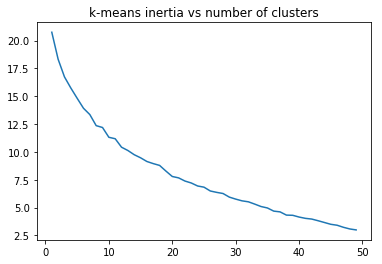

In [329]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# plot k-means inertia (to be minimized) vs number of clusters k. Select knee point in graph
ax.plot(k_val, k_inertia)

# Title of the plot
ax.set_title('k-means inertia vs number of clusters')

plt.show()

In [378]:
kmeans.labels_

array([ 4,  2,  4, 13, 12,  4,  7,  4,  4,  7,  3,  4,  1,  4,  9,  0,  5,
        7,  7,  7,  7,  2,  7,  7,  7,  4, 18,  7,  1,  7,  4,  4,  2,  7,
        4,  0,  0,  5, 10,  4,  0,  1,  3, 11,  1, 19,  4,  4,  7,  1,  4,
        4,  7,  7,  7,  4,  4,  7,  4,  7,  7,  8,  0,  7,  3,  7,  1,  3,
       15, 17,  0,  2,  3,  7,  7,  7,  7,  7,  7,  1,  1,  1, 16,  7,  4,
        7,  7, 14,  7,  0,  7,  7,  7,  7,  7,  7,  7,  1,  1,  7,  7,  4,
        1,  7,  7,  7,  4,  1,  7,  7,  7,  7,  1,  4,  4,  7,  7,  1,  7,
        7,  1,  4,  4,  6,  4,  0,  4,  4,  7, 16, 10,  4,  4, 15],
      dtype=int32)

<h2 id="creating_visual_plot">Creating the Visual Plot</h2>
So now that we have the data and the KMeans model initialized, let's plot them and see what it looks like!

Please read through the code and comments to understand how to plot the model.

In [488]:
# select basic info and feb 2019 home value data columns from zill_MSP_df to merge with venue data
cols3 = zill_MSP_df.columns.tolist()
cols3 = cols3[0:8] + cols3[-1:]
#cols3

In [461]:
MSP_merged.head()

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55044,Lakeville,44.669564,-93.26654,MN,Minneapolis-St. Paul-Bloomington,Dakota County,779,352000,<map object at 0x7f0b8c148b00>,Home Service,Golf Course,Convenience Store,Construction & Landscaping,Performing Arts Venue,Department Store,Disc Golf,Restaurant,Salon / Barbershop,Sandwich Place
1,55337,Burnsville,44.770297,-93.27302,MN,Minneapolis-St. Paul-Bloomington,Dakota County,806,273500,<map object at 0x7f0b8c148b00>,Coffee Shop,Pizza Place,Hotel,Sandwich Place,Intersection,Salon / Barbershop,Chinese Restaurant,Park,ATM,Diner
2,55106,Saint Paul,44.967565,-93.05001,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,841,185600,<map object at 0x7f0b8c148b00>,Mexican Restaurant,Pharmacy,Asian Restaurant,Gym / Fitness Center,Grocery Store,Park,Fast Food Restaurant,Video Store,Sandwich Place,Pizza Place
3,55104,Saint Paul,44.953665,-93.15922,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,955,234800,<map object at 0x7f0b8c148b00>,Coffee Shop,Pizza Place,Thrift / Vintage Store,Fast Food Restaurant,Bakery,Gym / Fitness Center,Korean Restaurant,Gym,Sporting Goods Shop,Grocery Store
4,55408,Minneapolis,44.947515,-93.28742,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,1238,286600,<map object at 0x7f0b8c148b00>,Coffee Shop,Pizza Place,Gym,Bar,American Restaurant,Salon / Barbershop,Comedy Club,Asian Restaurant,Chinese Restaurant,Ramen Restaurant


In [489]:
# create MSP_merged as seed for merging with venues data
MSP_merged = zill_MSP_df[cols3]

In [490]:
# give feb 2019 home value data a more descriptive name
MSP_merged.rename(columns={'2019-02':'Feb-2019 Median Home Value'}, inplace=True)

In [465]:
MSP_merged.head()

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value
0,55044,Lakeville,44.669564,-93.26654,MN,Minneapolis-St. Paul-Bloomington,Dakota County,779,352000
1,55337,Burnsville,44.770297,-93.27302,MN,Minneapolis-St. Paul-Bloomington,Dakota County,806,273500
2,55106,Saint Paul,44.967565,-93.05001,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,841,185600
3,55104,Saint Paul,44.953665,-93.15922,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,955,234800
4,55408,Minneapolis,44.947515,-93.28742,MN,Minneapolis-St. Paul-Bloomington,Hennepin County,1238,286600


In [470]:
# drop clustering labels
city_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)

In [467]:
# add clustering labels
#city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [487]:
city_venues_sorted['ZipCode'].shape

(134,)

In [491]:
MSP_merged['ZipCode'].shape

(136,)

In [473]:
# merge home value by zipcode and geocoordinates with venue data
MSP_merged = MSP_merged.join(city_venues_sorted.set_index('ZipCode'), on='ZipCode')

In [475]:
MSP_merged.insert(0,'Cluster Labels', kmeans.labels_)

ValueError: Length of values does not match length of index

In [433]:
# rename Cluster Labels to Cluster_Labels
#MSP_merged.rename(columns={'Cluster Labels':'Cluster_Labels'}, inplace=True)

In [458]:
#MSP_merged['Cluster Labels'] = map(int,MSP_merged['Cluster Labels'])

In [459]:
#MSP_merged.Cluster_Labels = MSP_merged.Cluster_Labels.astype(object)

In [460]:
#MSP_merged.Cluster_Labels = MSP_merged.Cluster_Labels.astype(int)

In [449]:
#MSP_merged.Cluster_Labels = MSP_merged.Cluster_Labels.astype(object)
MSP_merged.dtypes

ZipCode         int64
City           object
Latitude      float64
Longitude     float64
State          object
Metro          object
CountyName     object
SizeRank        int64
2019-02         int64
dtype: object

### __Visualize data__

In [438]:
# set st. paul as map starting point
latitude = zill_MSP_df.loc[3,'Latitude']
longitude = zill_MSP_df.loc[3,'Longitude']
print(latitude, longitude)

44.953665 -93.15922


In [441]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MSP_merged['Latitude'], MSP_merged['Longitude'], MSP_merged['City'], MSP_merged['Cluster_Labels']):
    print(type(cluster))
#    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
#    folium.CircleMarker(
#        [lat, lon],
#        radius=5,
#        popup=label,
#        color=rainbow[cluster-1],
#        fill=True,
#        fill_color=rainbow[cluster-1],
#        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class '

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1  ?

In [292]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 1, MSP_merged.columns[[0] + [1] + list(range(5, MSP_merged.shape[1]))]]

,ZipCode,City,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,55337,Burnsville,Minneapolis-St. Paul-Bloomington,Dakota County,806,273500,1,Coffee Shop,Pizza Place,Hotel,Chinese Restaurant,Sandwich Place,Park,Salon / Barbershop,Intersection,ATM,Pub
7,55406,Minneapolis,Minneapolis-St. Paul-Bloomington,Hennepin County,1555,262300,1,Coffee Shop,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Liquor Store,Mexican Restaurant,Playground,Video Store,Antique Shop,Gastropub
10,55330,Elk River,Minneapolis-St. Paul-Bloomington,Sherburne County,1958,264600,1,Pizza Place,Coffee Shop,Grocery Store,Fast Food Restaurant,Thrift / Vintage Store,Building,Restaurant,Bakery,Cosmetics Shop,Shoe Store
11,55407,Minneapolis,Minneapolis-St. Paul-Bloomington,Hennepin County,1999,254700,1,Mexican Restaurant,Park,Coffee Shop,American Restaurant,Bakery,Grocery Store,Chinese Restaurant,Taco Place,Discount Store,Pizza Place
14,55418,Minneapolis,Minneapolis-St. Paul-Bloomington,Hennepin County,2457,259400,1,Park,Mexican Restaurant,Sandwich Place,Liquor Store,Coffee Shop,Brewery,Pizza Place,Gym,Fast Food Restaurant,American Restaurant
16,55343,Hopkins,Minneapolis-St. Paul-Bloomington,Hennepin County,2837,258000,1,Coffee Shop,Pizza Place,Gym / Fitness Center,Rental Car Location,Fast Food Restaurant,Chinese Restaurant,Grocery Store,American Restaurant,Liquor Store,Video Store
19,55016,Cottage Grove,Minneapolis-St. Paul-Bloomington,Washington County,3041,259600,1,Fast Food Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Chinese Restaurant,Salon / Barbershop,Mexican Restaurant,Liquor Store,Park,American Restaurant


#### Cluster 4  ?

In [294]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 2, MSP_merged.columns[[0] + [1] + list(range(5, MSP_merged.shape[1]))]]

,ZipCode,City,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,55117,Saint Paul,Minneapolis-St. Paul-Bloomington,Ramsey County,1475,213500,2,Fast Food Restaurant,Grocery Store,Park,Music Venue,Pharmacy,Bar,Pub,Discount Store,Video Store,Sandwich Place
9,55119,Saint Paul,Minneapolis-St. Paul-Bloomington,Ramsey County,1687,212700,2,Fast Food Restaurant,Pizza Place,Sandwich Place,Hotel,Chinese Restaurant,Coffee Shop,Park,Pharmacy,Mexican Restaurant,Bar


## 4. Cluster Cities
Run *k*-means to cluster the cities. Use graph to figure out how many clusters are optimum. Use dataset that includes median home value.

In [35]:
# set number of clusters
kclusters = 5

MSP_grouped_clustering = MSP_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(MSP_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 3, 4, 1, 4, 4, 4, 2, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [43]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

MSP_merged = zill_MSP_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
MSP_merged = MSP_merged.join(city_venues_sorted.set_index('ZipCode'), on='ZipCode')

MSP_merged.head() # check the last columns!

,ZipCode,City,State,Latitude,Longitude,Metro,CountyName,SizeRank,2014-01,2014-02,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55124,Apple Valley,MN,44.731909,-93.217720,Minneapolis-St. Paul-Bloomington,Dakota County,472,210700.0,212900.0,...,Fast Food Restaurant,Pizza Place,Coffee Shop,Mobile Phone Shop,Asian Restaurant,American Restaurant,Gym / Fitness Center,Chinese Restaurant,Mexican Restaurant,Sandwich Place
1,55044,Lakeville,MN,44.650051,-93.243279,Minneapolis-St. Paul-Bloomington,Dakota County,779,272600.0,273700.0,...,Skating Rink,Gym,American Restaurant,Brewery,Sandwich Place,Pizza Place,Salon / Barbershop,Beach,Coffee Shop,Restaurant
2,55337,Burnsville,MN,44.767742,-93.277723,Minneapolis-St. Paul-Bloomington,Dakota County,806,209600.0,210700.0,...,Coffee Shop,Sandwich Place,Salon / Barbershop,American Restaurant,Grocery Store,Furniture / Home Store,Gym / Fitness Center,Liquor Store,Pizza Place,Park
3,55106,Saint Paul,MN,44.950404,-93.101503,Minneapolis-St. Paul-Bloomington,Ramsey County,841,120900.0,122100.0,...,American Restaurant,Coffee Shop,Park,Pizza Place,Italian Restaurant,Hotel,Bar,Farmers Market,History Museum,Brewery
4,55303,Ramsey,MN,45.016573,-93.094950,Minneapolis-St. Paul-Bloomington,Anoka County,850,183600.0,183000.0,...,Fast Food Restaurant,Bar,Donut Shop,Sandwich Place,Pizza Place,Pharmacy,Chinese Restaurant,Liquor Store,Grocery Store,Burger Joint


In [59]:
#MSP_merged[['ZipCode', 'City', 'Cluster Labels']]

In [54]:
MSP_merged['Cluster Labels'].value_counts()

0    185
4     12
3      1
2      1
1      1
Name: Cluster Labels, dtype: int64

Finally, let's visualize the resulting clusters

In [47]:
latitude = zill_MSP_df.iloc[3,3]
longitude = zill_MSP_df.iloc[3,4]

In [255]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MSP_merged['Latitude'], MSP_merged['Longitude'], MSP_merged['City'], MSP_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1  ?

In [56]:
#MSP_merged.loc[MSP_merged['Cluster Labels'] == 0, MSP_merged.columns[[1] + list(range(5, MSP_merged.shape[1]))]]

#### Cluster 4  ?

In [58]:
#MSP_merged.loc[MSP_merged['Cluster Labels'] == 4, MSP_merged.columns[[1] + list(range(5, MSP_merged.shape[1]))]]